In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_uniform(batch_size):
    return torch.rand(batch_size, 1)

In [3]:
def get_normal(batch_size):
    return torch.randn(batch_size, 1) + 5

In [4]:
class Generator(nn.Module):
    def __init__(self):
        
        """Generator transform the uniform distribution to the normal distribution"""
        
        super().__init__()
        self.main = nn.Sequential(
                    nn.Linear(in_features = 1, out_features = 16),
                    nn.ReLU(),
                    nn.Linear(in_features = 16, out_features = 1)
        )
    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    
    def __init__(self):
        """disc(x) return probability of x to be real class"""
        super().__init__()
        self.main = nn.Sequential(
                    nn.Linear(in_features = 1, out_features = 16),
                    nn.ReLU(),
                    nn.Linear(in_features = 16, out_features = 1),
                    nn.Sigmoid()
    
            )
    def forward(self, x):
        return self.main(x)
    
gen = Generator()
disc = Discriminator()

### Defining the optimizer of the system

In [5]:
generator_opt = torch.optim.SGD(gen.parameters(), lr = 1e-3)
discriminator_opt = torch.optim.SGD(disc.parameters(), lr = 1e-3)

In [6]:
def update_D(batch_size):
    """
    1. sample real data
    2. Compute probability of real object to be real
    """
    
    real_samples = get_normal(batch_size)
    prob_real_is_real = disc(real_samples)
    
    
    """
    1. sample noise
    2. ontain generated samples
    3. compute probability of fake objet to be fake
    """
    
    noise = get_uniform(batch_size)
    generated_samples = gen(noise)
    prob_fake_is_fake = 1 - disc(generated_samples)
    
    
    # compute loss function
    loss = (- torch.log(prob_real_is_real) - torch.log(prob_fake_is_fake)).mean()
    
    #make gradient step
    discriminator_opt.zero_grad()
    loss.backward()
    discriminator_opt.step()
    
    return loss.data.numpy().item()

In [7]:
def update_G(batch_size):
    #. sample noise
    #. obtain generated samples
    #. compute probability of fake object to be real
    
    noise = get_uniform(batch_size)
    generated_samples = gen(noise)
    prob_fake_is_real = disc(generated_samples)
    
    #compute loss function
    
    loss = (-torch.log(prob_fake_is_real)).mean()
    
    # make gradient step
    generator_opt.zero_grad()
    loss.backward()
    generator_opt.step()
    
    return loss.data.numpy().item()

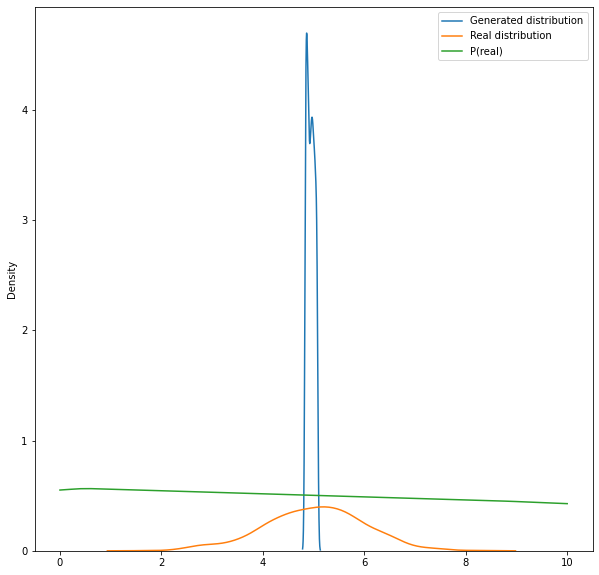

In [8]:

N_DISC_OPERATIONS = 10 #number of updates for the discriminator on each iteration(should be tuned)
BATCH_SIZE = 64


for i in range(10000):
    
    for _ in range(N_DISC_OPERATIONS):
        update_D(BATCH_SIZE)
        
    update_G(BATCH_SIZE)
    
    if i % 100 == 0:
        clear_output(True)
        plt.figure(figsize = [10, 10])
        
        sns.kdeplot(gen(get_uniform(1000)).data.numpy()[:, 0], label = 'Generated distribution')
        sns.kdeplot(get_normal(1000).data.numpy()[:, 0], label = 'Real distribution')
        
        x = np.linspace(0, 10, dtype = 'float32')
        p_real = disc(torch.from_numpy(x[:, None]))
        plt.plot(x, p_real.data.numpy(), label = 'P(real)')
        
        #axes = plt.gca()
        #axes.set_ylim([0,1])
        plt.legend()
        plt.show()